# LEONARDO: An Introduction to Training the Model

### Overview
#### This notebook demonstrates how to:
#### 1. Load and prepare training, validation and test datasets.
#### 2. Initialize the LEONARDO model.
#### 3. Train the model.
#### 4. Explore the latent space.
#### 5. Generate synthetic trajectories.

### Requirements
#### Ensure the following files are in the same directory as this notebook:
#### - `LEONARDO_utils.py` - python file containing all the helper functions
#### - `LEONARDO_model.py` - python file containing the LEONARDO model and model training code
#### - `lptem_train.npy` - numpy file containing the training dataset.
#### - `lptem_test.npy` - numpy file containing the test dataset.
#### - `lptem_val.npy` - numpy file containing the validation dataset.
#### - (optional) `LEONARDOModel` - pre-trained LEONARDO model

In [53]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from LEONARDO_utils import prepare_dataset, autocorrelation_dx_torch, kurtosis_torch, skewness_torch, variance_torch, mean_torch, normalize
import LEONARDO_model
from matplotlib.colors import Normalize, LinearSegmentedColormap
from sklearn.metrics import r2_score
from numpy.polynomial.polynomial import Polynomial
from matplotlib.lines import Line2D  # For custom legends
from scipy import stats
from scipy.stats import f
import seaborn as sns
from matplotlib import cm
from matplotlib import colormaps  # Updated method for accessing colormaps

# Step 1: Set up the Environment

In [33]:
# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Step 2: Load Trajectory Data

In [34]:
# Provide the file paths to your trajectory datasets
trainset_path = 'lptem_train.npy'
valset_path = 'lptem_val.npy'
testset_path = 'lptem_test.npy'

# Load datasets
trainset = np.load(trainset_path)[:, :, 0:2]
valset = np.load(valset_path)[:, :, 0:2]
testset = np.load(testset_path)[:, :, 0:2]

print(f"Loaded training set with shape: {trainset.shape}")
print(f"Loaded validation set with shape: {valset.shape}")
print(f"Loaded test set with shape: {testset.shape}")

# Prepare datasets for PyTorch
trainset_torch = prepare_dataset(trainset, shuffle=True, norm=True)
valset_torch = prepare_dataset(valset, shuffle=True, norm=True)
testset_torch = prepare_dataset(testset, shuffle=True, norm=True)

Loaded training set with shape: (38279, 200, 2)
Loaded validation set with shape: (3202, 200, 2)
Loaded test set with shape: (5934, 200, 2)


# Step 3: Train the LEONARDO Model

### Initialize the model

In [35]:
# Define training hyperparameters
epochs = 10  # Training epochs
batch_size = 1000  # Batch size
learning_rate = 3e-4  # Learning rate
weight_decay = 1e-5  # Weight decay

# Select GPU if available
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Initialize the LEONARDO model
model = LEONARDO_model.TransformerVAE(device=device).to(device)

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay, lr=learning_rate)

### Prepare Data loaders

In [36]:
dataloader = DataLoader(trainset_torch, batch_size=batch_size, num_workers=4, shuffle=True)
validation_loader = DataLoader(valset_torch, batch_size=batch_size, num_workers=4, shuffle=True)

### Start training

In [6]:
# Start training the LEONARDO model
print("Starting training...")
model.train_Leonardo(epochs, dataloader, optimizer, device, val_loader=validation_loader)

# Save the trained model
parameters = {
    'Batch Size': batch_size,
    'Learning Rate': learning_rate,
    'Weight Decay': weight_decay,
    'Optimizer': 'Adam',
    'Trajectory Types': 'LPTEM',
    'Training Dataset Size': trainset_torch.shape[0],
    'Validation Dataset Size': valset_torch.shape[0],
    'Random Seed': random_seed,
    'Normalization type': '0 to 1'
}
model_name = 'leonardo_model_trained'
model.save_model(parameters, model_name)

print(f"Training completed. Model saved as {model_name}.")

Starting training...

epoch [1/10], Training loss:11.65, KL-div training loss:2.0, MSE training loss:0.04, Kurtosis training loss:25.65, Skewness training loss (x10e3):629.60, Var training loss (x10e5):163.93, Mean training loss (x10e7):64.01, Median training loss (x10e7):757.39,acorr training loss (x10e3):1.38, acorr batch training loss (x10e4):26.85, xycorr factor training loss (x10e3): 47.764,pos acorr training loss (x10e3): 456.442
Validation loss:8.54, KL-div val loss:0.7, MSE val loss:0.02, Kurtosis val loss:14.43, Skewness val loss (x10e3):499.32, Var val loss (x10e5):19.64, Mean val loss (x10e7):62.02, Median val loss (x10e7):319.40, acorr val loss (x10e3):1.08, acorr batch val loss (x10e4):9.08, xycorr val loss (x10e3): 65.338, pos acorr val loss (x10e3): 423.051
epoch [2/10], Training loss:9.35, KL-div training loss:1.4, MSE training loss:0.02, Kurtosis training loss:18.83, Skewness training loss (x10e3):589.74, Var training loss (x10e5):12.48, Mean training loss (x10e7):54.9

### (Optional) Load an already trained model

In [37]:
# if you want to load in an already trained model:
device = 'cpu'
model = LEONARDO_model.TransformerVAE(device=device).to(device)
model.load_model('LEONARDOModel')

Model Loaded


### Visualize Training Loss

<Figure size 3600x1500 with 0 Axes>

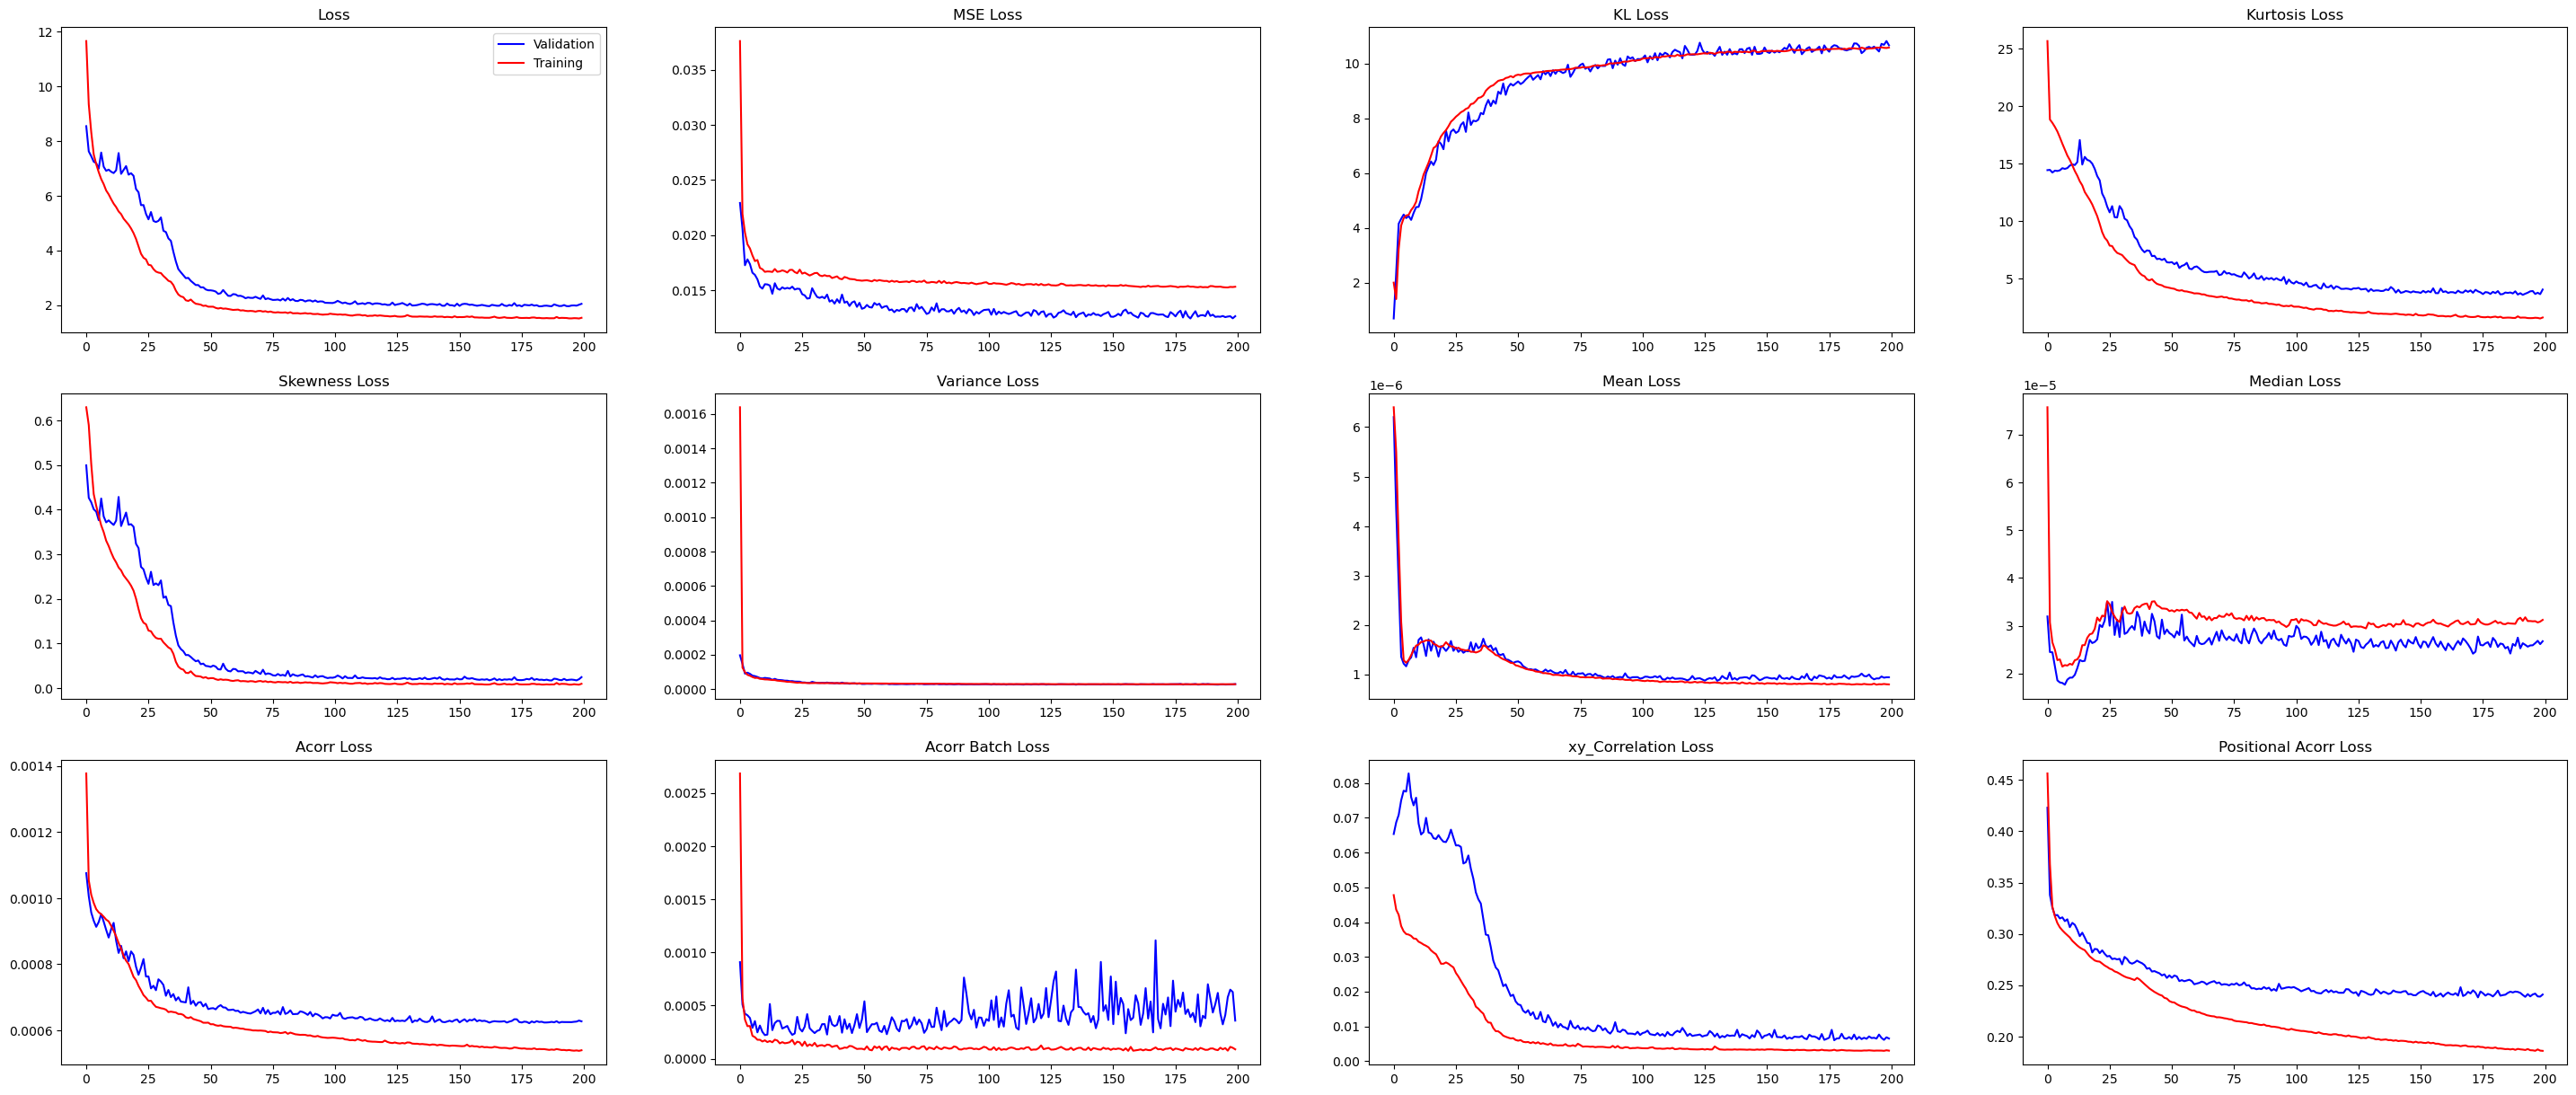

In [38]:
# Plot training loss
device='cpu'
model.plot_loss(logscale=False, split='both')

# Step 4: Latent Space Exploration

### See how some statistical properties vary with latent variable values

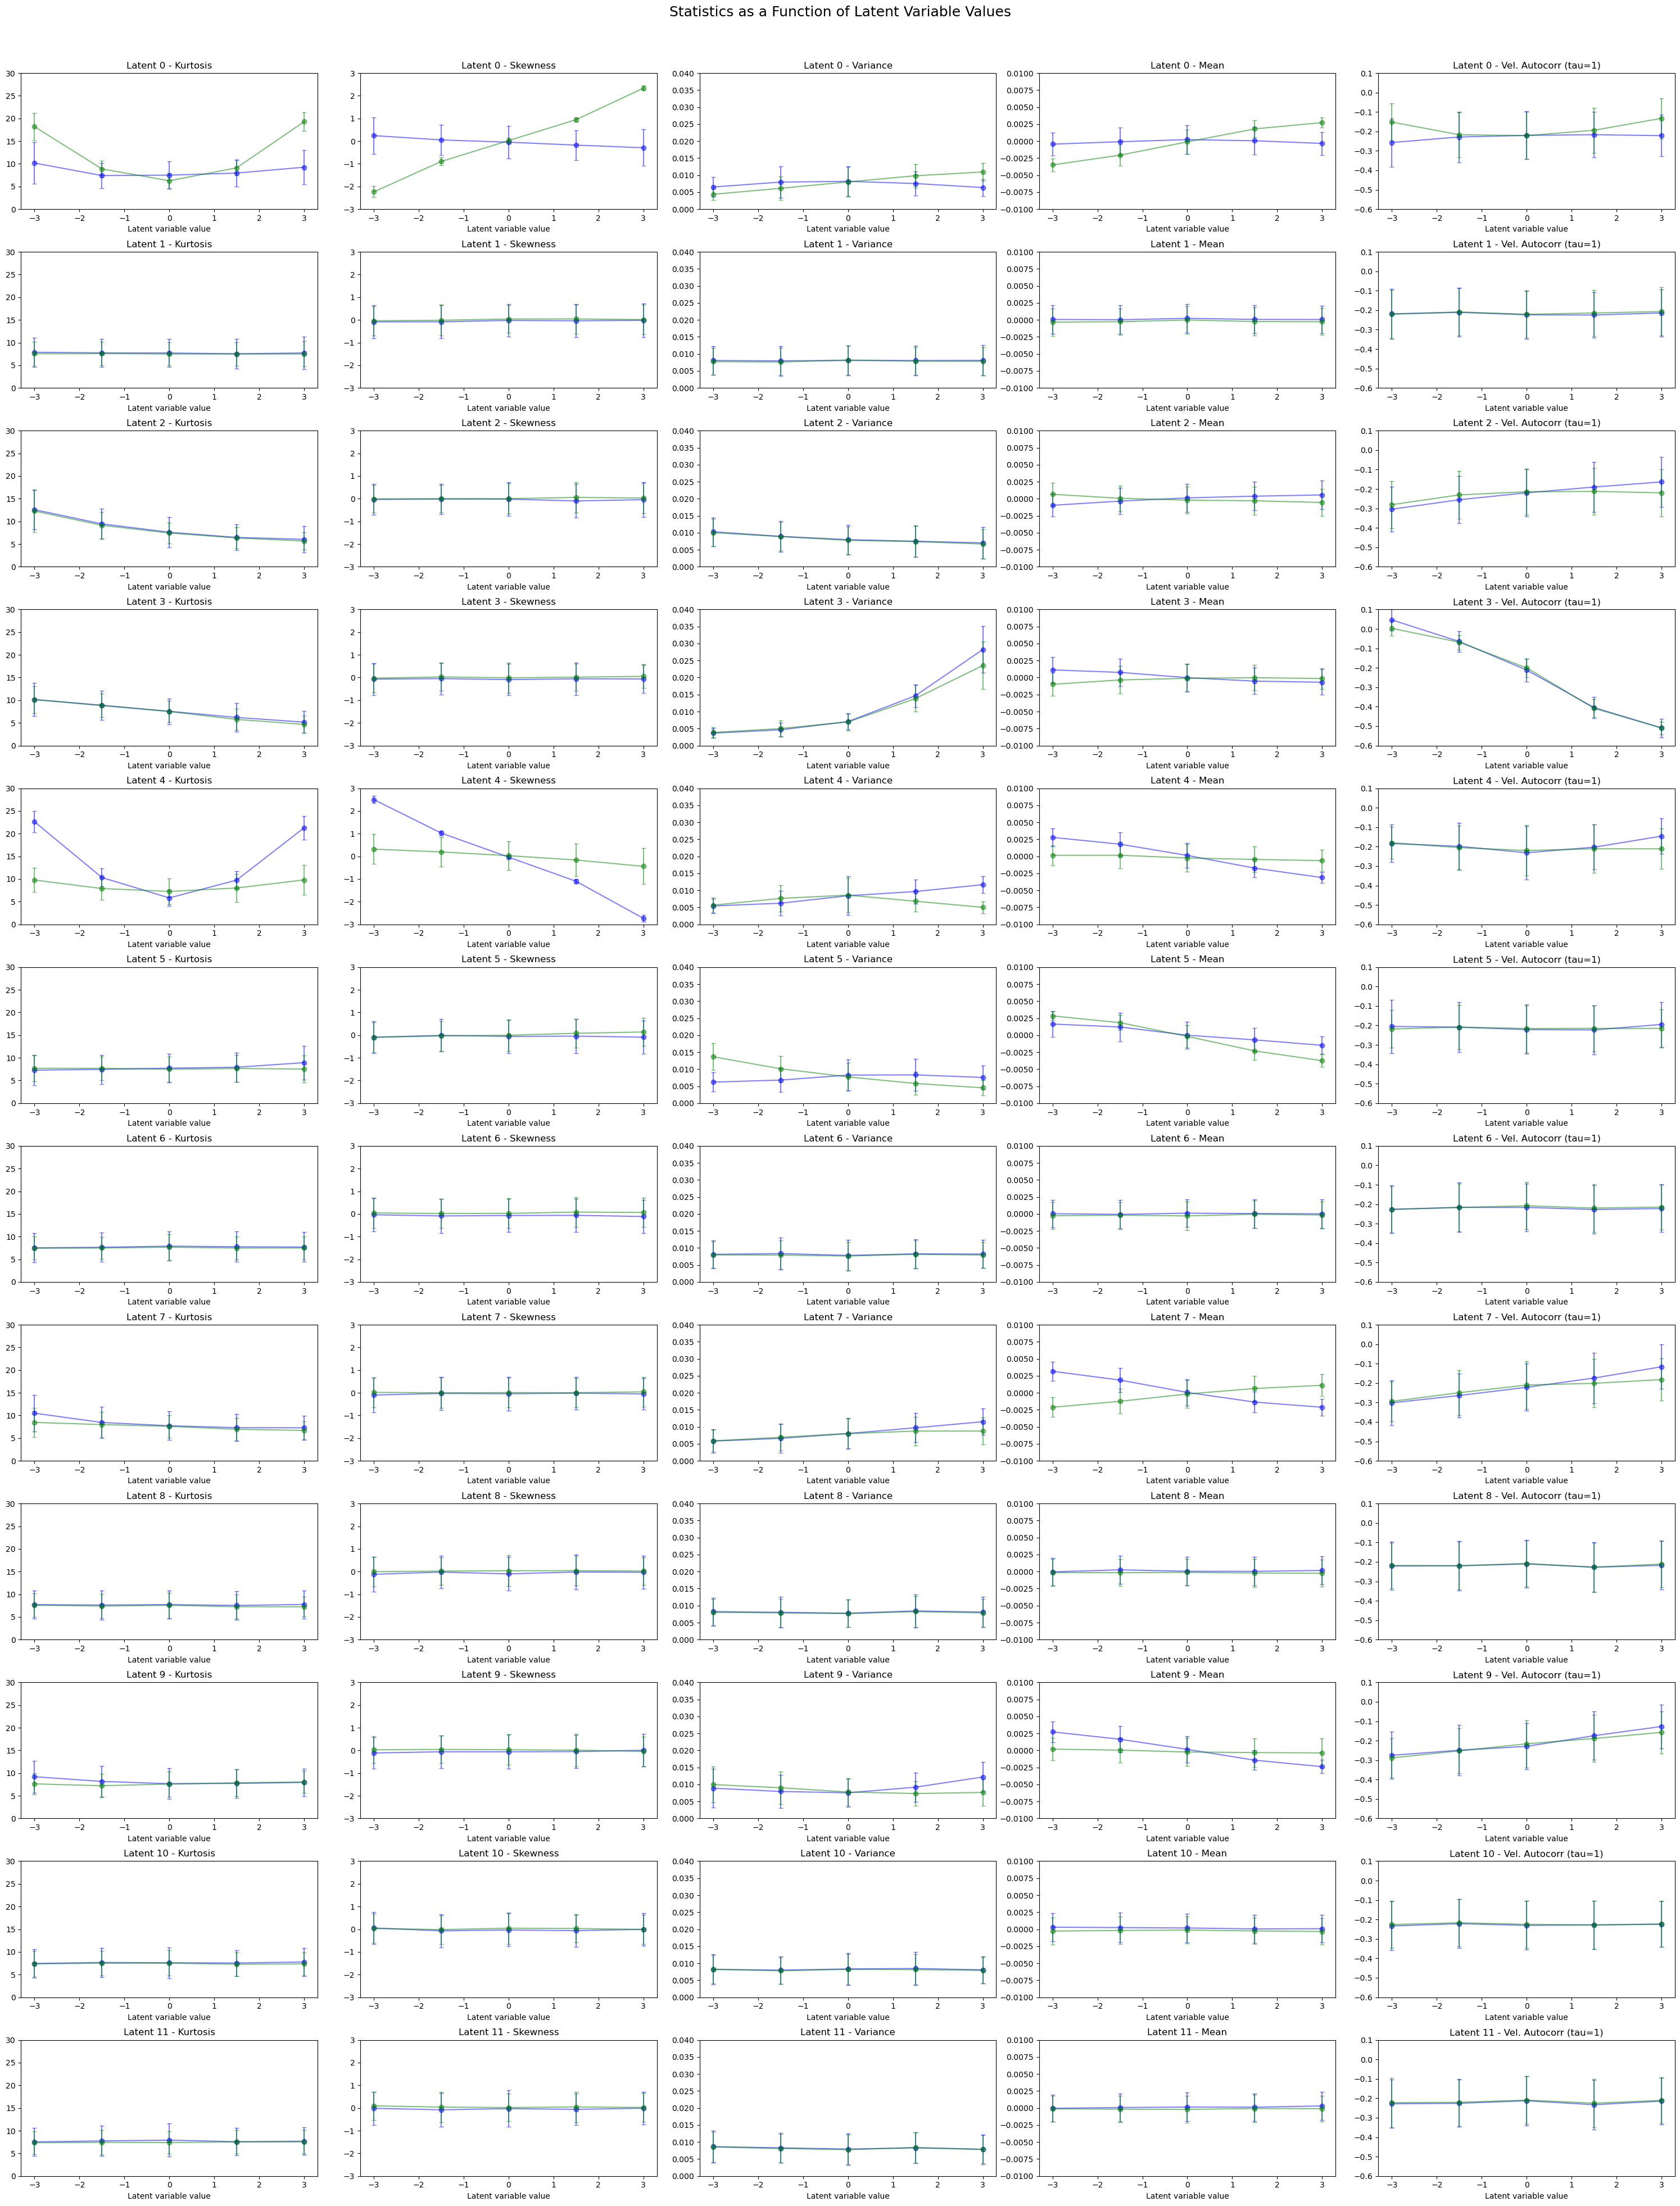

In [39]:
# Set parameters
num_trajectories = 500
timesteps = 200
latent_dim = 12 
torch.manual_seed(490)

# Define the latent values to explore for each variable
latent_values = [-3, -1.5, 0, 1.5, 3]
num_columns = len(latent_values)

# Define arrays to store average statistics for the final plot
avg_kurtosis = np.zeros((latent_dim, len(latent_values), 2))  # Separate for x and y
avg_skewness = np.zeros((latent_dim, len(latent_values), 2))
avg_variance = np.zeros((latent_dim, len(latent_values), 2))
avg_mean = np.zeros((latent_dim, len(latent_values), 2))
avg_autocorr_tau1 = np.zeros((latent_dim, len(latent_values), 2))


std_kurtosis = np.zeros((latent_dim, len(latent_values), 2))
std_skewness = np.zeros((latent_dim, len(latent_values), 2))
std_variance = np.zeros((latent_dim, len(latent_values), 2))
std_mean = np.zeros((latent_dim, len(latent_values), 2))
std_autocorr_tau1 = np.zeros((latent_dim, len(latent_values), 2))


# Plot setup
fig, axs = plt.subplots(latent_dim, 5, figsize=(30, 40))  # Adjust columns to include all statistics
fig.suptitle("Statistics as a Function of Latent Variable Values", fontsize=18)


# Loop over latent variables and latent values
for i in range(latent_dim):
    for j, value in enumerate(latent_values):  # Exclude the last column
        # Generate random latent codes
        en = torch.randn(num_trajectories, model.latent_space)
        en[:, i] = value  # Vary only the i-th latent variable

        # Decode to generate trajectories
        with torch.no_grad():
            dec = model.decoder(en).numpy()

        # Calculate trajectory displacements
        dec_dx = np.diff(dec, axis=1)

        # Calculate statistics
        kurtosis_vals = kurtosis_torch(torch.from_numpy(dec_dx)).numpy()
        skewness_vals = skewness_torch(torch.from_numpy(dec_dx)).numpy()
        variance_vals = variance_torch(torch.from_numpy(dec_dx)).numpy()
        mean_vals = mean_torch(torch.from_numpy(dec_dx)).numpy()
        autocorr_vals = autocorrelation_dx_torch(torch.from_numpy(dec)).numpy()
    
        

        # Store averages and standard deviations
        avg_kurtosis[i, j] = kurtosis_vals.mean(axis=0)
        avg_skewness[i, j] = skewness_vals.mean(axis=0)
        avg_variance[i, j] = variance_vals.mean(axis=0)
        avg_mean[i, j] = mean_vals.mean(axis=0)
        avg_autocorr_tau1[i, j] = autocorr_vals[:, 1].mean(axis=0)


        std_kurtosis[i, j] = kurtosis_vals.std(axis=0)
        std_skewness[i, j] = skewness_vals.std(axis=0)
        std_variance[i, j] = variance_vals.std(axis=0)
        std_mean[i, j] = mean_vals.std(axis=0)
        std_autocorr_tau1[i, j] = autocorr_vals[:, 1].std(axis=0)


    # Plot each statistic
    axs[i, 0].errorbar(latent_values, avg_kurtosis[i,:,0], yerr=std_kurtosis[i,:,0], marker='o', color='b', linestyle='-', capsize=3,alpha=0.5, label="Kurtosis (x)")
    axs[i, 0].errorbar(latent_values, avg_kurtosis[i,:,1], yerr=std_kurtosis[i,:,1], marker='o', color='g', linestyle='-', capsize=3,alpha=0.5, label="Kurtosis (y)")
    axs[i, 0].set_ylim(0, 30)
    axs[i, 0].set_xlabel('Latent variable value')
    if i == 0 and j == 0:  # Only add legend to the first row, first column plot
        axs[i, 0].legend(['x', 'y'], loc='upper left', fontsize=12)

    axs[i, 1].errorbar(latent_values, avg_skewness[i,:,0], yerr=std_skewness[i,:,0], marker='o', color='b', linestyle='-', capsize=3,alpha=0.5, label="Skewness (x)")
    axs[i, 1].errorbar(latent_values, avg_skewness[i,:,1], yerr=std_skewness[i,:,1], marker='o', color='g', linestyle='-', capsize=3,alpha=0.5, label="Skewness (y)")
    axs[i, 1].set_ylim(-3, 3)
    axs[i, 1].set_xlabel('Latent variable value')

    axs[i, 2].errorbar(latent_values, avg_variance[i,:,0], yerr=std_variance[i,:,0], marker='o', color='b', linestyle='-', capsize=3,alpha=0.5, label="Variance (x)")
    axs[i, 2].errorbar(latent_values, avg_variance[i,:,1], yerr=std_variance[i,:,1], marker='o', color='g', linestyle='-', capsize=3,alpha=0.5, label="Variance (y)")
    axs[i, 2].set_ylim(0, 0.04)
    axs[i, 2].set_xlabel('Latent variable value')

    axs[i, 3].errorbar(latent_values, avg_mean[i,:,0], yerr=std_mean[i,:,0], marker='o', color='b', linestyle='-', capsize=3,alpha=0.5, label="Mean (x)")
    axs[i, 3].errorbar(latent_values, avg_mean[i,:,1], yerr=std_mean[i,:,1], marker='o', color='g', linestyle='-', capsize=3,alpha=0.5, label="Mean (y)")
    axs[i, 3].set_ylim(-0.01, 0.01)
    axs[i, 3].set_xlabel('Latent variable value')

    axs[i, 4].errorbar(latent_values, avg_autocorr_tau1[i,:,0], yerr=std_autocorr_tau1[i,:,0], marker='o', color='b', linestyle='-', capsize=3,alpha=0.5, label="Vel. Autocorr (x, tau=1)")
    axs[i, 4].errorbar(latent_values, avg_autocorr_tau1[i,:,1], yerr=std_autocorr_tau1[i,:,1], marker='o', color='g', linestyle='-', capsize=3,alpha=0.5, label="Vel. Autocorr (y, tau=1)")
    axs[i, 4].set_ylim(-0.6, 0.1)
    axs[i, 4].set_xlabel('Latent variable value')

    # Set titles for each row
    axs[i, 0].set_title(f"Latent {i} - Kurtosis")
    axs[i, 1].set_title(f"Latent {i} - Skewness")
    axs[i, 2].set_title(f"Latent {i} - Variance")
    axs[i, 3].set_title(f"Latent {i} - Mean")
    axs[i, 4].set_title(f"Latent {i} - Vel. Autocorr (tau=1)")


# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()


### Relationships between Latent variables and non-Gaussianity and Velocity Autocorrelation 

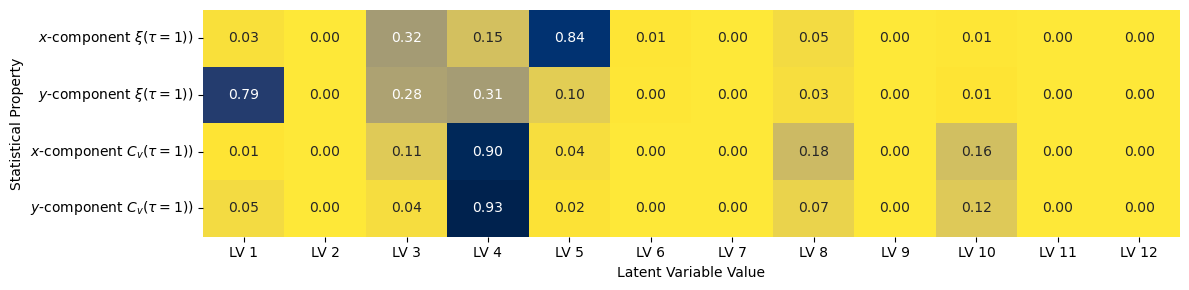

In [40]:
# Parameters
latent_dim = 12
num_samples = 1000
tau_point = 1  # Velocity autocorrelation at τ=1

# Generate Latent Variable Samples
latent_values = np.random.uniform(-3, 3, (num_samples, latent_dim))

# Initialize matrices for R² and p-values
r2_matrix = np.zeros((latent_dim, 4))
pval_matrix = np.zeros((latent_dim, 4))

# Function to compute R² and p-value
def compute_p_value(y, y_fit, num_params):
    residuals = y - y_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - (ss_res / ss_tot)
    df_residuals = len(y) - num_params - 1  # Degrees of freedom for residuals
    df_model = num_params  # Degrees of freedom for model
    f_stat = (r2 / (1 - r2)) * (df_residuals / df_model)
    p_value = 1 - f.cdf(f_stat, df_model, df_residuals)
    return r2, p_value

# Compute R² and p-values for all latent variables
for i in range(latent_dim):
    latent_var_values = latent_values[:, i]
    other_latent_values = np.random.randn(num_samples, latent_dim)
    other_latent_values[:, i] = latent_var_values

    with torch.no_grad():
        dec = model.decoder(torch.tensor(other_latent_values, dtype=torch.float32)).numpy()

    delta_x_tau1 = dec[:, 1:, 0] - dec[:, :-1, 0]
    delta_y_tau1 = dec[:, 1:, 1] - dec[:, :-1, 1]
    msd_x = np.mean(delta_x_tau1**2, axis=1)
    msd_y = np.mean(delta_y_tau1**2, axis=1)
    fourth_x = np.mean(delta_x_tau1**4, axis=1)
    fourth_y = np.mean(delta_y_tau1**4, axis=1)

    nongaussianity_x = (1 / 3) * (fourth_x / (msd_x**2)) - 1
    nongaussianity_y = (1 / 3) * (fourth_y / (msd_y**2)) - 1

    autocorrs = autocorrelation_dx_torch(torch.tensor(dec, dtype=torch.float32)).numpy()
    autocorr_x = autocorrs[:, tau_point, 0]
    autocorr_y = autocorrs[:, tau_point, 1]

    # Polynomial fit (degree 2) and calculate R² and p-values for non-gaussianity
    poly_fit_x = Polynomial.fit(latent_var_values, nongaussianity_x, deg=2)
    poly_fit_y = Polynomial.fit(latent_var_values, nongaussianity_y, deg=2)
    y_fit_x = poly_fit_x(latent_var_values)
    y_fit_y = poly_fit_y(latent_var_values)

    r2_matrix[i, 0], pval_matrix[i, 0] = compute_p_value(nongaussianity_x, y_fit_x, num_params=2)
    r2_matrix[i, 1], pval_matrix[i, 1] = compute_p_value(nongaussianity_y, y_fit_y, num_params=2)

    # Polynomial fit (degree 2) and calculate R² and p-values for autocorrelation
    poly_fit_x = Polynomial.fit(latent_var_values, autocorr_x, deg=2)
    poly_fit_y = Polynomial.fit(latent_var_values, autocorr_y, deg=2)
    y_fit_x = poly_fit_x(latent_var_values)
    y_fit_y = poly_fit_y(latent_var_values)

    r2_matrix[i, 2], pval_matrix[i, 2] = compute_p_value(autocorr_x, y_fit_x, num_params=2)
    r2_matrix[i, 3], pval_matrix[i, 3] = compute_p_value(autocorr_y, y_fit_y, num_params=2)

# Transpose the R² matrix
r2_matrix_transposed = r2_matrix.T

# Plot the transposed R² heatmap
plt.figure(figsize=(12, 3))  # Adjusted dimensions for horizontal layout
sns.heatmap(r2_matrix_transposed, annot=True, fmt=".2f", cmap="cividis_r",
            xticklabels=[f"LV {i+1}" for i in range(latent_dim)],
            yticklabels=[r"$x$-component $\xi(\tau=1)$)", r"$y$-component $\xi(\tau=1)$)", r"$x$-component $C_v(\tau=1)$)", r"$y$-component $C_v(\tau=1)$)"],
            cbar_kws={"orientation": "horizontal"},cbar=False)
plt.xlabel("Latent Variable Value")
plt.ylabel("Statistical Property")
plt.tight_layout()
plt.show()

### Plot a chosen latent variable versus non-Gaussianity and Velocity autocorrelation

Middle Row - R² for Non-Gaussianity (x): 0.0479, p-value: 2.3192e-11
Middle Row - R² for Non-Gaussianity (y): 0.7825, p-value: 1.1102e-16
Bottom Row - R² for Velocity Autocorrelation (x): 0.0034, p-value: 1.8268e-01
Bottom Row - R² for Velocity Autocorrelation (y): 0.0578, p-value: 1.3045e-13


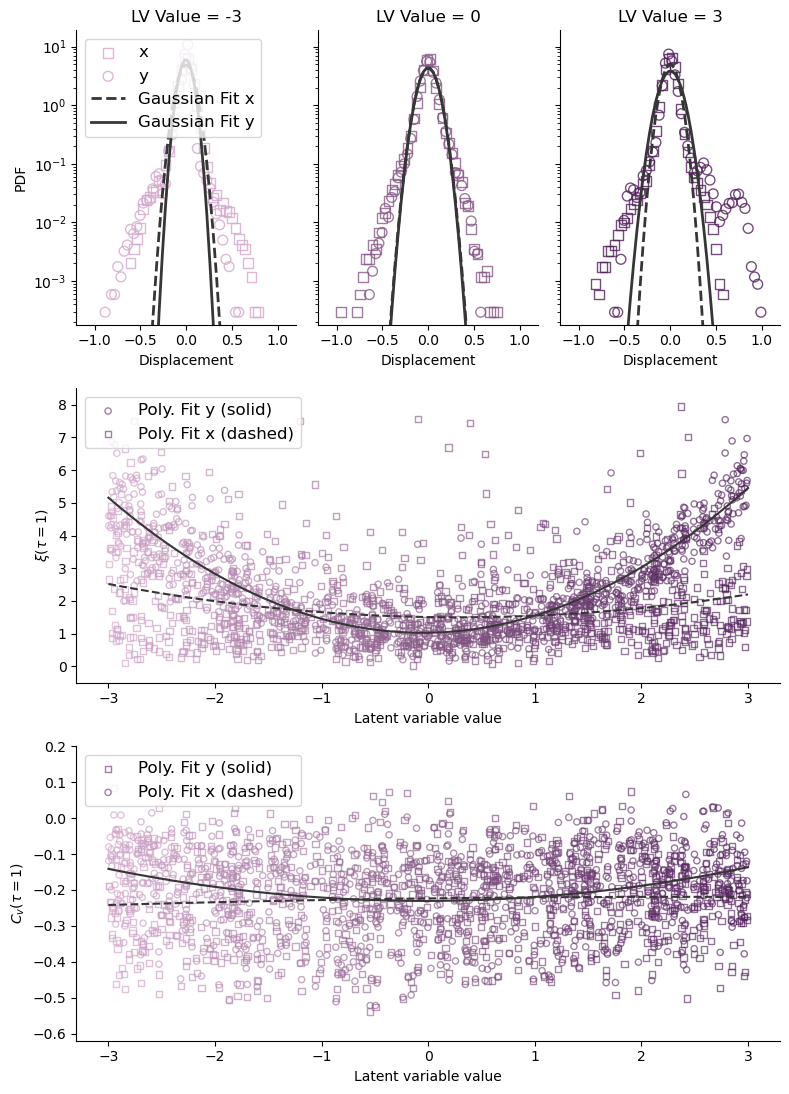

In [41]:
# Parameters
latent_dim = 12
latent_idx = 0  # Current latent variable to analyze
selected_latent_values = [-3, 0, 3]
num_samples = 1000  # Number of samples
tau_point = 1  # Velocity autocorrelation at τ=1

# Define custom gradient colors
colors = ['#D3A9CD', '#875B87', '#52215C']
cmap = LinearSegmentedColormap.from_list("custom_gradient", colors)
norm = Normalize(vmin=-3, vmax=3)  # Normalize latent variable range

# Generate Latent Variable Samples
latent_values = np.random.uniform(-3, 3, num_samples)  # Uniform distribution for the selected latent variable
gradient_colors = cmap(norm(latent_values))  # Map latent values to custom gradient colors
other_latent_values = np.random.randn(num_samples, latent_dim)  # Gaussian distribution for others
other_latent_values[:, latent_idx] = latent_values  # Replace the selected latent variable

# Function to compute p-value for polynomial regression
def compute_p_value(y, y_fit, num_params):
    residuals = y - y_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - (ss_res / ss_tot)
    df_residuals = len(y) - num_params - 1  # Degrees of freedom for residuals
    df_model = num_params  # Degrees of freedom for model
    f_stat = (r2 / (1 - r2)) * (df_residuals / df_model)
    p_value = 1 - f.cdf(f_stat, df_model, df_residuals)
    return r2, p_value

# Create figure
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(3, len(selected_latent_values), height_ratios=[1, 1, 1])

# --- Top Row: Displacement Distribution ---
axs_top = [fig.add_subplot(gs[0, col_idx]) for col_idx in range(len(selected_latent_values))]
for col_idx, value in enumerate(selected_latent_values):
    en = torch.randn(500, latent_dim)
    en[:, latent_idx] = value
    with torch.no_grad():
        dec = model.decoder(en).numpy()

    delta_x = dec[:, 1:, 0] - dec[:, :-1, 0]
    delta_y = dec[:, 1:, 1] - dec[:, :-1, 1]

    # Compute histograms
    hist_x, _ = np.histogram(delta_x.flatten(), bins=np.linspace(-1.2, 1.2, 71), density=True)
    hist_y, _ = np.histogram(delta_y.flatten(), bins=np.linspace(-1.2, 1.2, 71), density=True)

    # Fit Gaussian to x and y displacements
    mu_x, sigma_x = np.mean(delta_x.flatten()), np.std(delta_x.flatten())
    mu_y, sigma_y = np.mean(delta_y.flatten()), np.std(delta_y.flatten())
    gaussian_fit_x = stats.norm.pdf(np.linspace(-1.2, 1.2, 70), mu_x, sigma_x)
    gaussian_fit_y = stats.norm.pdf(np.linspace(-1.2, 1.2, 70), mu_y, sigma_y)

    # Plot histograms and Gaussian fits
    axs_top[col_idx].scatter(np.linspace(-1.2, 1.2, 70), hist_x, edgecolors=colors[col_idx], facecolors='none', alpha=0.8, label="x", s=50, marker='s')
    axs_top[col_idx].scatter(np.linspace(-1.2, 1.2, 70), hist_y, edgecolors=colors[col_idx], facecolors='none', alpha=0.8, label="y", s=50, marker='o')

    axs_top[col_idx].plot(np.linspace(-1.2, 1.2, 70), gaussian_fit_x, linestyle="--", color='#363636', linewidth=2, label="Gaussian Fit x")
    axs_top[col_idx].plot(np.linspace(-1.2, 1.2, 70), gaussian_fit_y, linestyle="-", color='#363636', linewidth=2, label="Gaussian Fit y")

    axs_top[col_idx].set_title(f"LV Value = {value}")
    axs_top[col_idx].set_yscale("log")
    axs_top[col_idx].set_ylim([1.8e-4, 1.9e1])
    axs_top[col_idx].set_xlim([-1.2, 1.2])
    axs_top[col_idx].set_xlabel("Displacement")
    axs_top[col_idx].spines['right'].set_visible(False)
    axs_top[col_idx].spines['top'].set_visible(False)
    if col_idx == 0:
        axs_top[col_idx].set_ylabel("PDF")
    else:
        axs_top[col_idx].tick_params(labelleft=False)

    if col_idx == 0:
        axs_top[col_idx].legend(loc='upper left', fontsize=12)

# --- Middle Row: Non-Gaussianity Scatter Plot ---
ax_middle = fig.add_subplot(gs[1, :])
nongaussianity_x = []
nongaussianity_y = []

with torch.no_grad():
    dec = model.decoder(torch.tensor(other_latent_values, dtype=torch.float32)).numpy()

delta_x_tau1 = dec[:, 1:, 0] - dec[:, :-1, 0]
delta_y_tau1 = dec[:, 1:, 1] - dec[:, :-1, 1]
msd_x = np.mean(delta_x_tau1**2, axis=1)
msd_y = np.mean(delta_y_tau1**2, axis=1)
fourth_x = np.mean(delta_x_tau1**4, axis=1)
fourth_y = np.mean(delta_y_tau1**4, axis=1)

nongaussianity_x = (1 / 3) * (fourth_x / (msd_x**2)) - 1
nongaussianity_y = (1 / 3) * (fourth_y / (msd_y**2)) - 1


# Plot Scatter
for i in range(num_samples):
    ax_middle.scatter(latent_values[i], nongaussianity_y[i], edgecolors=gradient_colors[i], facecolors='none', alpha=0.65, marker="o", s=20)
    ax_middle.scatter(latent_values[i], nongaussianity_x[i], edgecolors=gradient_colors[i], facecolors='none', alpha=0.65, marker="s", s=20)

# Polynomial Fit
poly_fit_x = Polynomial.fit(latent_values, nongaussianity_x, 2)
poly_fit_y = Polynomial.fit(latent_values, nongaussianity_y, 2)
x_fit = np.linspace(-3, 3, 100)
ax_middle.plot(x_fit, poly_fit_x(x_fit), linestyle="--", color="#363636", label="Poly. Fit x")
ax_middle.plot(x_fit, poly_fit_y(x_fit), linestyle="-", color="#363636", label="Poly. Fit y")
ax_middle.set_ylim([-0.5, 8.5])
ax_middle.spines['right'].set_visible(False)
ax_middle.spines['top'].set_visible(False)
ax_middle.set_ylabel(r'$\xi(\tau=1)$')
ax_middle.legend(['Poly. Fit y (solid)', 'Poly. Fit x (dashed)'], loc='upper left', fontsize=12)
ax_middle.set_xlabel('Latent variable value')


# R² and p-value for Non-Gaussianity
r2_middle_x, p_value_middle_x = compute_p_value(nongaussianity_x, poly_fit_x(latent_values), 2)
r2_middle_y, p_value_middle_y = compute_p_value(nongaussianity_y, poly_fit_y(latent_values), 2)

print(f"Middle Row - R² for Non-Gaussianity (x): {r2_middle_x:.4f}, p-value: {p_value_middle_x:.4e}")
print(f"Middle Row - R² for Non-Gaussianity (y): {r2_middle_y:.4f}, p-value: {p_value_middle_y:.4e}")

# --- Bottom Row: Velocity Autocorrelation Scatter Plot ---
ax_bottom = fig.add_subplot(gs[2, :])
autocorr_x = []
autocorr_y = []

# Compute velocity autocorrelation
autocorrs = autocorrelation_dx_torch(torch.tensor(dec, dtype=torch.float32)).numpy()
autocorr_x = autocorrs[:, tau_point, 0]
autocorr_y = autocorrs[:, tau_point, 1]

# Plot Scatter
for i in range(num_samples):
    ax_bottom.scatter(latent_values[i], autocorr_x[i], edgecolors=gradient_colors[i], facecolors='none', alpha=0.65, marker="s", s=20)
    ax_bottom.scatter(latent_values[i], autocorr_y[i], edgecolors=gradient_colors[i], facecolors='none', alpha=0.65, marker="o", s=20)

# Polynomial Fit
poly_fit_x = Polynomial.fit(latent_values, autocorr_x, 2)
poly_fit_y = Polynomial.fit(latent_values, autocorr_y, 2)
ax_bottom.plot(x_fit, poly_fit_x(x_fit), linestyle="--", color="#363636", label="Poly. Fit x")
ax_bottom.plot(x_fit, poly_fit_y(x_fit), linestyle="-", color="#363636", label="Poly. Fit y")
ax_bottom.set_ylim([-0.62, 0.2])
ax_bottom.spines['right'].set_visible(False)
ax_bottom.spines['top'].set_visible(False)
ax_bottom.set_ylabel(r'$C_v(\tau=1)$')
ax_bottom.set_xlabel('Latent variable value')
ax_bottom.legend(['Poly. Fit y (solid)', 'Poly. Fit x (dashed)'], loc='upper left', fontsize=12)


# R² and p-value for Velocity Autocorrelation
r2_bottom_x, p_value_bottom_x = compute_p_value(autocorr_x, poly_fit_x(latent_values), 2)
r2_bottom_y, p_value_bottom_y = compute_p_value(autocorr_y, poly_fit_y(latent_values), 2)

print(f"Bottom Row - R² for Velocity Autocorrelation (x): {r2_bottom_x:.4f}, p-value: {p_value_bottom_x:.4e}")
print(f"Bottom Row - R² for Velocity Autocorrelation (y): {r2_bottom_y:.4f}, p-value: {p_value_bottom_y:.4e}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Step 5: Generate Trajectories

### Function to generate trajectories

In [56]:
def generate_and_plot_trajectories(model, num_trajectories=12, fixed_latents=None, figsize=(30, 20)):
    """
    Generate and plot trajectories from the model's decoder.

    Parameters:
    model: The trained LEONARDO model
    num_trajectories: The number of trajectories to generate (default is 12).
    fixed_latents: A list of dictionaries with fixed latent values for specific trajectories.
                   Example: [{1: 0, 11: 0}, {2: -3}] will fix latent variables 1 and 11 to 0 for the first trajectory,
                   and latent variable 2 to -3 for the second trajectory.
    figsize: A tuple specifying the size of the figure (default is (30, 20)).

    Returns:
    dec: Numpy array of all generated trajectories.
    """
    # Use Viridis colormap
    viridis = colormaps['viridis']  # Updated colormap access

    torch.manual_seed(490)
    with torch.no_grad():
        en = torch.randn(num_trajectories, model.latent_space)
        
        if fixed_latents:
            for idx, latents in enumerate(fixed_latents):
                for latent_idx, value in latents.items():
                    en[idx, latent_idx-1] = value
        
        dec = model.decoder(en).numpy()
        dec = normalize(dec)
    
    # Plotting the first 20 trajectories
    num_plots = min(num_trajectories, 20)
    cols = 4
    rows = (num_plots + cols - 1) // cols
    
    plt.figure(figsize=figsize)
    
    for i in range(num_plots):  
        plt.subplot(rows, cols, i + 1)
        num_points = dec.shape[1]  # Number of time points in each trajectory
        viridis = plt.colormaps['viridis']  # Access the Viridis colormap

        # Plot each segment of the trajectory with a color from Viridis
        for t in range(num_points - 1):
            plt.plot(
                dec[i, t:t+2, 0],  # x-coordinates of the segment
                dec[i, t:t+2, 1],  # y-coordinates of the segment
                color=viridis(t / num_points),  # Assign color based on time step
                linewidth=1.5
            )

        plt.xlabel(r'$x$ Position')
        plt.ylabel(r'$y$ Position')
        plt.title(f'Trajectory {i+1}')
        plt.gca().set_aspect('equal', 'datalim')  # Maintain equal aspect ratio
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()  # Show all subplots together as a grid
    
    return dec

### Generate trajectories with random values of latent variables

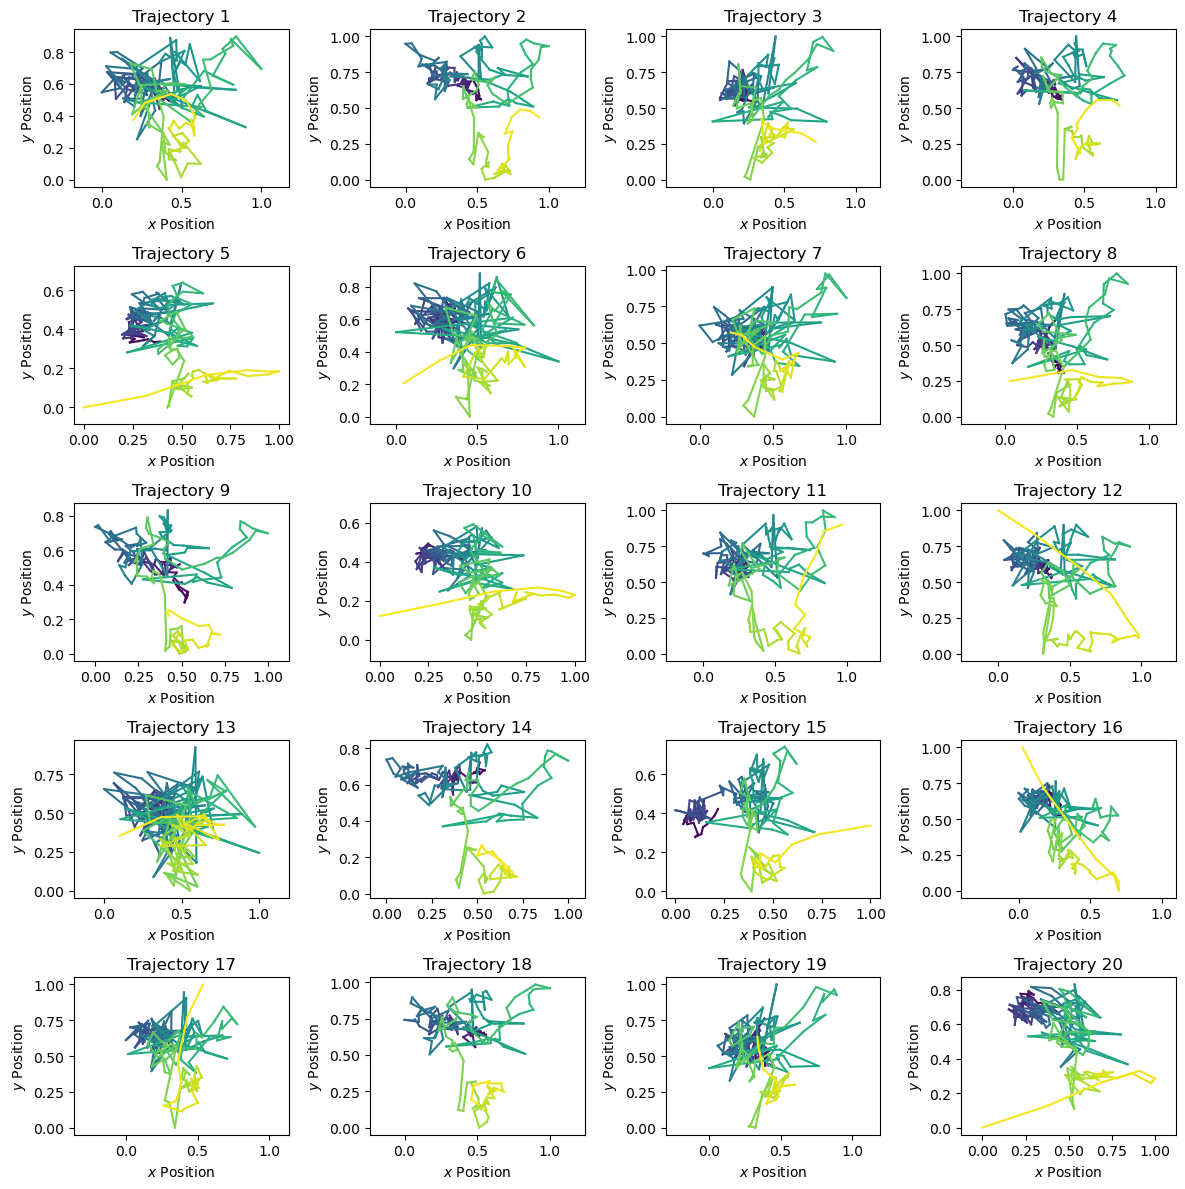

In [57]:
generated_trajectories = generate_and_plot_trajectories(model, num_trajectories=25, figsize=(12, 12))

### Generate trajectories with
#### (1) High latent variable 4 value
#### (2) high latent variable 1 value
#### (3) high latent variable 5 value

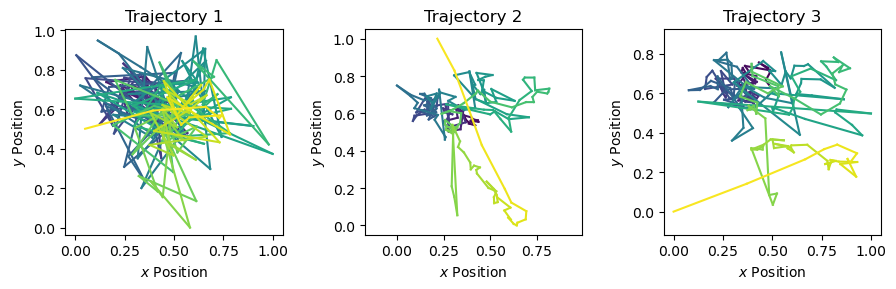

In [58]:
generated_trajectories = generate_and_plot_trajectories(model, num_trajectories=3, fixed_latents=[{4: 3}, {1: 3}, {5: 3}], figsize=(12, 3))